In [1]:
#Load some pacakges to extract coast coordinates, manage data and calculate distances
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapely as sp
import numpy as np
from scipy import spatial
from sklearn.neighbors import NearestNeighbors
from pyproj import Proj, transform
import os
import pandas as pd
import cartopy.io.shapereader as shpreader

In [2]:
from pprint import pprint
#Get NaturalEarh data using the Cartopy interface
'''
Store shp files locally, but do it in a more programatically way)
This functions will download medium resolution shapefiles for the
whole planet.
'''

ne_earth = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')


reader = shpreader.Reader(ne_earth)
countries = reader.records()

def extract_geom_meta(country):
    '''
    Extract from each geometry the name of the country
    and the geom_point data. The output will be a list 
    of tuples and the country name as the last element.
    '''
    geoms = country.geometry
    for geom in geoms: 
        x,y = geom.exterior.xy
     
    meta_data = country.attributes["ADMIN"]
    return [*zip(x,y), meta_data]

world_geoms = [extract_geom_meta(country) for country in countries]
print(world_geoms[3])
#Does ir works? Let's try with a simple example. 
#print(world_geoms[21])
#x, y = [list(c) for c in zip(*world_geoms[21][:-1])]
#plt.plot(x, y)
#plt.show()

[(-63.42357337099986, 18.60004303600006), (-63.42796790299994, 18.592840887000122), (-63.42882239499994, 18.60126373900006), (-63.42357337099986, 18.60004303600006), 'Anguilla']


In [3]:
coords_countries_names = np.vstack([[np.array(ls[:-1]), ls[-1]]
                     for ls in world_geoms
                   ])


print(len(coords_countries_names[0][0]))
coords = np.vstack([ls[0] for ls in coords_countries_names])
countries = np.hstack([np.repeat(ls[1], len(ls[0])) for ls in coords_countries_names])
print(countries[1:27])
print(len(countries), len(coords))

26
['Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba'
 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba'
 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Aruba' 'Afghanistan']
232773 232773


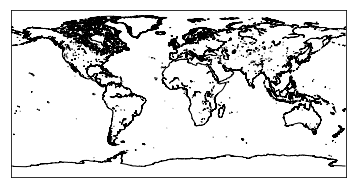

In [5]:
#MPL Apporach using Basemap - Deprecated (no country ID)
m = Basemap(epsg = '4326', resolution = 'i')
coast = m.drawcoastlines()
coordinates = np.vstack(coast.get_segments())
lons,lats = m(coordinates[:,0],coordinates[:,1])

#Plot :) 
fig = plt.figure(1, figsize=(100, 100), dpi=90)
ax = fig.add_subplot(111)
plt.show()

In [6]:
print(coordinates[0:10])
len(coordinates)

[[-180.           68.99377441]
 [-179.62835693   68.89622498]
 [-179.24169922   68.85372162]
 [-178.4609375    68.58258057]
 [-178.71092224   68.67580414]
 [-178.71755981   68.54413605]
 [-176.75921631   67.98999786]
 [-176.96847534   67.97872162]
 [-176.78503418   67.97541809]
 [-176.78503418   67.97541809]]


119642

In [11]:
from sqlalchemy import *
from geoalchemy2 import *
from sqlalchemy import func
from sqlalchemy.engine.url import URL
from sqlalchemy.orm import *

#Create connection with the Database (db = wef)

import database #Import Python file with a dict with the file configurations

def db_connect():
    """
    Performs database connection using database settings from settings.py.
    Returns sqlalchemy engine instance
    """
    return create_engine(URL(**database.DATABASE))


# Create the engine and the session connection to the Database
engine = db_connect()
connection = engine.connect()

#Load table (ais_position) from SQL database
metadata = MetaData()
ais_position = Table('may_june_17_position', 
                 metadata, autoload=True,
                 schema = "ais_messages",
                 autoload_with=engine)

#Print variable names and len
print(ais_position.columns)
#print(len(ais_position.columns))

# Open a bound session on the database. This facilitates work and create a better workflow
Session = sessionmaker(bind=engine)
session = Session()

#Spatial query: only select AIS positional messages inside the Torres Strait
#wkt_string = "POLYGON((141.0205078125 -9.166331387642987, 143.602294921875 -9.155485188844034, 143.67919921875 -11.112885070321443, 140.965576171875 -11.11288507032144, 141.0205078125 -9.166331387642987))"
wkt_string =  "POLYGON((139.0 -9.0, 145.0 -9.0, 145 -12, 139 -12, 139 -9))"
q = select([ais_position], ais_position.c.geom.intersects(wkt_string))


['may_june_17_position.msg_type', 'may_june_17_position.mmsi', 'may_june_17_position.timestamp', 'may_june_17_position.nmea', 'may_june_17_position.status', 'may_june_17_position.rot', 'may_june_17_position.speed', 'may_june_17_position.accuracy', 'may_june_17_position.longitude', 'may_june_17_position.latitude', 'may_june_17_position.course', 'may_june_17_position.heading', 'may_june_17_position.manever', 'may_june_17_position.geom']


In [12]:
#Execture query with the connection object
results = connection.execute(q)
names_ais =  ais_position.columns
partial_results = results.fetchall()
results_df = pd.DataFrame(partial_results, columns=names_ais)

In [115]:
from scipy import stats

longitude = results_df[results_df.columns[8]]
print(type(longitude))
latitude = results_df[results_df.columns[9]]
print(type(latitude))
df = pd.concat([longitude, latitude], axis=1)
df = data_ais[["longitude", "latitude"]]
print(type(df))
print(df.shape)

#points = results_df.as_matrix([results_df.columns[8:10]])
points = df.as_matrix([df.columns[0:2]])

def proj_arr(points,proj_to):
    """
    Project geographic co-ordinates to get cartesian x,y
    Transform(origin|destination|lon|lat)
    """
    inproj = Proj(init='epsg:4326')
    outproj = Proj(init=proj_to)
    func = lambda x: transform(inproj,outproj,x[0],x[1])
    return np.array(list(map(func, points)))

points_proj = proj_arr(points,'epsg:3410')
coordinates_proj = proj_arr(coords, 'epsg:3410')
print(points_proj)
print(coordinates_proj)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
(3649258, 2)


RuntimeError: b'latitude or longitude exceeded limits'

In [14]:
from collections import Counter

#ScyPy approach with meter projection
distance,index = spatial.cKDTree(coordinates_proj, leafsize=16).query(points_proj)
print(distance[1:100])
print(stats.describe(distance))

Counter(countries[index])

df = pd.DataFrame({
    "distance_meters" : distance,
    "country" : countries[index]
})


[ 162097.17580483  154870.95835807  279103.35050049  211910.72947198
   87920.91107009  344964.92854749  227457.96521185  192105.69721831
  229279.07812478  163592.7398244   311696.29155803  158859.45823423
  282640.7706199   338643.80866662  161711.45069085  262079.67561267
  268011.14487407  266025.27919088  326768.55163009   38102.61699268
  273543.61297731  163871.4081796   223566.17558248  136648.75960228
  180627.68012871  225634.02708075  132269.72488396  266621.02711068
  161984.20243203  167252.5561533   111420.4517189   162810.96405077
  243963.37873766  163851.20073376  155737.42441635  286890.29842639
  151435.48355354  315309.56109818  192663.03613498  287970.53671738
  285059.94709682  223705.2987648   358075.10376533  259139.3646556
  120694.96607256  152695.22261907  289562.24877231   92974.79336238
  234895.57121794  285141.70448772  112694.66074761  116966.15380342
  114315.83060706  195772.44374455  231515.86950103  185373.81342006
  255850.69579643  114280.72741253 

In [15]:
df

,country,distance_meters
0,Australia,282776.119678
1,Australia,162097.175805
2,Australia,154870.958358
3,Australia,279103.350500
4,Australia,211910.729472
5,Australia,87920.911070
6,Australia,344964.928547
7,Australia,227457.965212
8,Australia,192105.697218
9,Australia,229279.078125


In [161]:
#Function to calculate distance from vessel to the nearest shore

def calculate_distance_to_shore(longitude, latitude, country_name=False):
    '''
    This function will create a numpy array of distances
    to shore. It will contain and ID for AIS points and 
    the distance to the nearest coastline point.
    '''
    
    def proj_arr(points,proj_to):
        """
        Project geographic co-ordinates to get cartesian x,y
        Transform(origin|destination|lon|lat) to meters.
        """
        inproj = Proj(init='epsg:4326')
        outproj = Proj(init=proj_to)
        func = lambda x: transform(inproj,outproj,x[0],x[1])
        return np.array(list(map(func, points)))
    
    if country_name == True:
        if not os.path.exists('data/coast_coords_country.npy'):
            '''
            Store shp files locally, but do it in a more programatically way)
            This functions will download medium resolution shapefiles for the
            whole planet.
            '''
            ne_earth = shpreader.natural_earth(resolution='10m',
                                               category='cultural',
                                               name='admin_0_countries')
            reader = shpreader.Reader(ne_earth)
            countries = reader.records()
        
            def extract_geom_meta(country):
                '''
                Extract from each geometry the name of the country
                and the geom_point data. The output will be a list 
                of tuples and the country name as the last element.
                '''
                geoms = country.geometry
                for geom in geoms: 
                    x,y = geom.exterior.xy
    
                meta_data = country.attributes["ADMIN"]
                return [*zip(x,y), meta_data]
        
            #Extract and create separate objects  
            world_geoms = [extract_geom_meta(country) for country in countries]  
            coords_countries_names = np.vstack([[np.array(ls[:-1]), ls[-1]] for ls in world_geoms])
            
            if not os.path.exists('data'):
                os.makedirs('data')
                np.save(os.path.join('data','coast_coords_country.npy'),coords_countries_names)
            
            else:
                np.save(os.path.join('data','coast_coords_country.npy'),coords_countries_names)
                print('Saving coordinates (...)')
              
            
        else:
            #Load coast data
            print('Loading coordinates (...)')
            

        coast = np.load('data/coast_coords_country.npy')
        coords = np.vstack([ls[0] for ls in coast])
        countries = np.hstack([np.repeat(ls[1], len(ls[0])) for ls in coast])
        
        #Load coordinates from ais
        df = pd.concat([longitude, latitude], axis=1)
        points = df.as_matrix([df.columns[0:2]])
        
    
        #Project to meters using 'proj_arr' function and calculate distance
        try: 
            coast_proj = proj_arr(coords, 'epsg:3410')
            points_proj = proj_arr(points, 'epsg:3410')
            distance,index = spatial.cKDTree(coast_proj).query(points_proj)
            distance_km = distance/1000

        except RuntimeError:
            print("Invalid coordinates for this point")
            
        
            
        #Return values: distance and country
        df = pd.DataFrame({
            "distance_km" : distance_km,
            "country" : countries[index]})
        return df
            
    else:
        
        if os.path.exists('data/coast_coords.npy') == False: 
            '''
            Extract from Basemap coastlines all the coordinates
            to calculate distances between them and the AIS GPS
            points. The map is in intermediate resolution (i),
            this avoid having a detailed and -probably- lengthy
            calculation.
            '''
            m = Basemap(epsg = '4326', resolution = 'i')
            coast = m.drawcoastlines()
            coordinates = np.vstack(coast.get_segments())
            lons,lats = m(coordinates[:,0],coordinates[:,1],inverse=True)
        
            coordinates_proj = proj_arr(coordinates, 'epsg:3410')
            
            if not os.path.exists('data'):
                os.makedirs('data')
                np.save(os.path.join('data','coast_coords.npy'),coordinates_proj)
            
            else:
                np.save(os.path.join('data','coast_coords.npy'),coordinates_proj)
    

        #Load coordinates from ais
        longitude = longitude
        latitude = latitude
        df = pd.concat([longitude, latitude], axis=1)
        points = df.as_matrix([df.columns[0:2]])
    
        #Project to meters using 'proj_arr' function and calculate distance 
        coast = np.load('data/coast_coords.npy')
        points_proj = proj_arr(points, 'epsg:3410')
        distance,index = spatial.cKDTree(coast).query(points_proj)
        distance_km = distance/1000
        
        #Add new column to input dataframe
        df = pd.DataFrame({
            "distance_km" : pd.Series(distance_km)  
            })
        return df

SyntaxError: 'continue' not properly in loop (<ipython-input-161-eb3fed8c0ba0>, line 82)

In [121]:
data_ais = pd.read_csv('data/ais_position_201607')


(1823019, 12)

(1808675, 12)


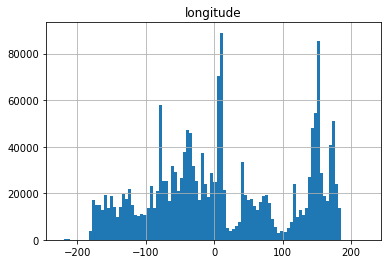

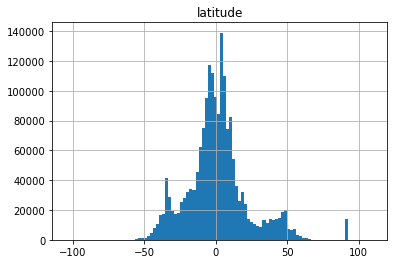

In [145]:
a = data_ais[(data_ais.longitude < 180) & (data_ais.longitude > -180) & (data_ais.latitude > -90) & (data_ais.latitude < 90)]
print(a.shape)
data_ais.hist(column='longitude', bins=100)
data_ais.hist(column='latitude', bins = 100)
plt.show()

In [160]:
prueba = calculate_distance_to_shore(data_ais["longitude"], data_ais["latitude"], country_name=True)

#print(coordinates[1:10])

#for x, y  in zip(lons[1:10], lats[1:10]):
#    print(x, y)

Loading coordinates (...)
Invalid coordinates for this point


UnboundLocalError: local variable 'points_proj' referenced before assignment

In [73]:
os.path.exists('data/coast_coords_country.npy')

True

In [147]:
prueba

,country,distance_km
0,Brazil,555.321039
1,Nigeria,1.463751
2,Peru,2356.397333
3,Suriname,1.868877
4,Gabon,568.452513
5,South Korea,372.794463
6,Dominica,334.268747
7,Morocco,113.196583
8,Brazil,1046.699039
9,Nauru,501.453197
